Please find torch implementation of this notebook here: https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/book1/19/finetune_cnn_torch.ipynb

<a href="https://colab.research.google.com/drive/1c0yus2G9AIHXjstUDGT9u7cXgAkJ4tCF?usp=sharing">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

**Author of the Notebook** : **Susnato Dhar** (**Github** **:** https://github.com/susnato)

**This notebook is JAX compatible version of the main notebook which can be found <a href="https://github.com/probml/probml-notebooks/blob/main/notebooks-d2l/finetune_cnn_torch.ipynb">here</a>.
<br>All the credits goes to the author of the main notebook, I just converted it to JAX.**

**I used <a href="https://github.com/n2cholas/jax-resnet">this repository</a> to impelement the pre-trained version of ResNet18 in order to fine tune it!<br>I used the Dataset HotDog VS No HotDog from this <a href="http://d2l-data.s3-accelerate.amazonaws.com/hotdog.zip">link</a>.**

In [ ]:
# Install Augmax for Image Augmentation
try:
    import augmax
except ModuleNotFoundError:
    %pip install -qq git+https://github.com/khdlr/augmax.git -q
    import augmax

# Install the  jax-resnet
try:
    import jax_resnet
except ModuleNotFoundError:
    %pip install -qq git+https://github.com/n2cholas/jax-resnet.git -q
    import jax_resnet

In [ ]:
# Download and Extract Data
!cd /content
!rm -rf /content/hotdog.zip /content/hotdog
!wget http://d2l-data.s3-accelerate.amazonaws.com/hotdog.zip
!unzip -qq /content/hotdog.zip -d /content/

--2022-06-08 21:01:56--  http://d2l-data.s3-accelerate.amazonaws.com/hotdog.zip
Resolving d2l-data.s3-accelerate.amazonaws.com (d2l-data.s3-accelerate.amazonaws.com)... 108.156.63.36
Connecting to d2l-data.s3-accelerate.amazonaws.com (d2l-data.s3-accelerate.amazonaws.com)|108.156.63.36|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 261292301 (249M) [application/zip]
Saving to: ‘hotdog.zip’

hotdog.zip          100%[===================>] 249.19M  36.7MB/s    in 7.7s    

2022-06-08 21:02:04 (32.5 MB/s) - ‘hotdog.zip’ saved [261292301/261292301]



**Imports**

In [ ]:
import os
import sys

try:
    import cv2
except ModuleNotFoundError:
    %pip install -qq opencv-python
    import cv2
import glob

try:
    import tqdm
except ModuleNotFoundError:
    %pip install -qq tqdm
    import tqdm
import shutil
from typing import Any
from IPython import display
import matplotlib.pyplot as plt

try:
    from skimage.util import montage
except ModuleNotFoundError:
    %pip install -qq scikit-image
    from skimage.util import montage

%matplotlib inline

In [ ]:
import jax
import jax.numpy as jnp
import jax.random as jrand

key = jrand.PRNGKey(42)

**Load Data**

In [ ]:
try:
    import tensorflow as tf
except ModuleNotFoundError:
    %pip install -qq tensorflow
    import tensorflow as tf


def load_img(dir, shape=False):
    img = cv2.imread(dir)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    if shape:
        img = cv2.resize(img, shape)
    return jnp.array(img)


augs = augmax.Chain(
    augmax.HorizontalFlip(), augmax.Resize(224, 224), augmax.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
)


def apply_augs(img, augs, key):
    img = augs(key, img)
    return img


class DataLoader(tf.keras.utils.Sequence):
    def __init__(self, batch_size, motiv, shuffle=False):
        self.batch_size = batch_size
        assert motiv in ["train", "test"]
        self.motiv = motiv
        self.hot_dogs_list = f"/content/hotdog/{motiv}/hotdog"
        self.non_hot_dogs_list = f"/content/hotdog/{motiv}/not-hotdog"
        self.key = jrand.PRNGKey(42)
        self.shuffle = shuffle

    def __len__(self):
        return len(os.listdir(self.hot_dogs_list)) // self.batch_size

    def __getitem__(self, ix):
        X, Y = [], []
        hdl = os.listdir(self.hot_dogs_list)[ix * self.batch_size : (ix + 1) * self.batch_size]
        nhdl = os.listdir(self.non_hot_dogs_list)[ix * self.batch_size : (ix + 1) * self.batch_size]

        for lst in zip(hdl, nhdl):
            X.append(apply_augs(load_img(os.path.join(self.hot_dogs_list, lst[0])), augs, self.key))
            Y.append(1)
            X.append(apply_augs(load_img(os.path.join(self.non_hot_dogs_list, lst[1])), augs, self.key))
            Y.append(0)

        X = jnp.array(X).reshape(self.batch_size * 2, 224, 224, 3).astype(jnp.float16)
        Y = (
            jnp.array(Y)
            .reshape(
                self.batch_size * 2,
            )
            .astype(jnp.uint8)
        )

        ix = jnp.arange(X.shape[0])
        ix = jrand.permutation(key, ix, independent=True)
        X = X[ix]
        Y = Y[ix]

        return X, Y

In [ ]:
train_dl = DataLoader(batch_size=32, motiv="train")
val_dl = DataLoader(batch_size=32, motiv="test")

Let's view some images(**Because the images are normalized so we need to first convert them to the range of 0 to 1**) in order to view them.

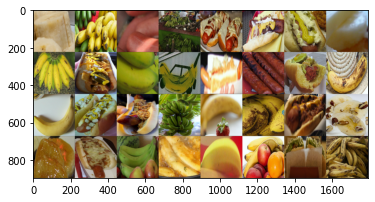

In [ ]:
example_x, example_y = train_dl.__getitem__(0)

viewable_imgs = example_x[:32]
viewable_imgs = (viewable_imgs - viewable_imgs.min()) / (viewable_imgs.max() - viewable_imgs.min())
viewable_imgs = viewable_imgs * 255.0
viewable_imgs = viewable_imgs.astype(jnp.uint8)
plt.imshow(montage(viewable_imgs, multichannel=True, grid_shape=(4, 8)))
plt.show();

**Model**


In [ ]:
import jax

try:
    import optax
except ModuleNotFoundError:
    %pip install -qq optax
    import optax
try:
    import flax.linen as nn
except ModuleNotFoundError:
    %pip install -qq flax
    import flax.linen as nn
from flax.training import train_state

try:
    from jax_resnet import pretrained_resnet, pretrained_resnest
except ModuleNotFoundError:
    %pip install -qq jax_resnet
    from jax_resnet import pretrained_resnet, pretrained_resnest

In [ ]:
class MyResnet(nn.Module):
    @nn.compact
    def __call__(self, data):
        ResNet18, _ = pretrained_resnet(18)
        model = ResNet18()
        model = nn.Sequential(model.layers[:-1])
        x = model(data)
        x = nn.Dense(features=256)(x)
        x = nn.relu(x)
        x = nn.Dense(features=2)(x)

        return x

In [ ]:
class TrainState(train_state.TrainState):
    batch_stats: Any


model = MyResnet()
vars = model.init(key, jnp.ones((1, 224, 224, 3)))
state = TrainState.create(
    apply_fn=model.apply, params=vars["params"], batch_stats=vars["batch_stats"], tx=optax.adam(learning_rate=0.00001)
)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [ ]:
@jax.jit
def compute_metrics(pred, true):
    loss = jnp.mean(optax.softmax_cross_entropy(logits=pred, labels=jax.nn.one_hot(true, num_classes=2)))
    pred = nn.softmax(pred)
    accuracy = jnp.mean(jnp.argmax(pred, -1) == true)
    return {"loss": loss, "accuracy": jnp.mean(accuracy)}


@jax.jit
def eval_step(state, batch):
    variables = {"params": state.params, "batch_stats": state.batch_stats}
    logits, _ = state.apply_fn(variables, batch["x"], mutable=["batch_stats"])
    return compute_metrics(pred=logits, true=batch["y"])

In [ ]:
def train(state, epochs):
    @jax.jit
    def bce_loss(params):
        y_pred, new_model_state = state.apply_fn(
            {"params": params, "batch_stats": state.batch_stats}, batch["x"], mutable=["batch_stats"]
        )
        y_true = jax.nn.one_hot(batch["y"], num_classes=2)
        loss = optax.softmax_cross_entropy(logits=y_pred, labels=y_true)
        return jnp.mean(loss), (new_model_state, y_pred)

    grad_fn = jax.value_and_grad(bce_loss, has_aux=True)

    for e in range(epochs):
        batch_metrics = []
        for i in range(train_dl.__len__()):
            batch = {}
            batch["x"], batch["y"] = train_dl.__getitem__(i)
            aux, grad = grad_fn(state.params)
            batch_loss, (new_model_state, batch_pred) = aux

            state = state.apply_gradients(grads=grad, batch_stats=new_model_state["batch_stats"])
            computed_metrics = compute_metrics(pred=batch_pred, true=batch["y"])
            sys.stdout.write(
                "\rEpoch : {}/{} Iteration : {}/{} Loss : {} Accuracy : {}".format(
                    e + 1, epochs, i + 1, train_dl.__len__(), computed_metrics["loss"], computed_metrics["accuracy"]
                )
            )
            batch_metrics.append(computed_metrics)

        print("\n")
        val_batch_loss, val_batch_acc = [], []
        for i in range(val_dl.__len__()):
            val_batch = {}
            val_batch["x"], val_batch["y"] = val_dl.__getitem__(i)
            val_metrics = eval_step(state, val_batch)
            val_batch_loss.append(val_metrics["loss"])
            val_batch_acc.append(val_metrics["accuracy"])

        eval_loss, eval_acc = jnp.mean(jnp.array(val_batch_loss)), jnp.mean(jnp.array(val_batch_acc))
        sys.stdout.write(
            "Validation Results : Epoch : {} Validation Loss : {} Validation Accuracy : {}".format(
                e + 1, jax.device_get(eval_loss), jax.device_get(eval_acc)
            )
        )
        print("\n")

    return state

**Training**

In [ ]:
epochs = 10
trained_state = train(state, epochs)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Epoch : 1/10 Iteration : 31/31 Loss : 0.6305527091026306 Accuracy : 0.84375



Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Validation Results : Epoch : 1 Validation Loss : 0.6439797878265381 Validation Accuracy : 0.7239583730697632

Epoch : 2/10 Iteration : 31/31 Loss : 0.5615583062171936 Accuracy : 0.875

Validation Results : Epoch : 2 Validation Loss : 0.6003700494766235 Validation Accuracy : 0.77734375

Epoch : 3/10 Iteration : 31/31 Loss : 0.5014811754226685 Accuracy : 0.875

Validation Results : Epoch : 3 Validation Loss : 0.5608120560646057 Validation Accuracy : 0.7994791865348816

Epoch : 4/10 Iteration : 31/31 Loss : 0.4480997920036316 Accuracy : 0.890625

Validation Results : Epoch : 4 Validation Loss : 0.5241073966026306 Validation Accuracy : 0.8151041865348816

Epoch : 5/10 Iteration : 31/31 Loss : 0.4001973569393158 Accuracy : 0.890625

Validation Results : Epoch : 5 Validation Loss : 0.49187132716178894 Validation Accuracy : 0.8255208730697632

Epoch : 6/10 Iteration : 31/31 Loss : 0.35695502161979675 Accuracy : 0.90625

Validation Results : Epoch : 6 Validation Loss : 0.4648681581020355 Valid

**Testing The Model**

<ul>
<li>0 = No HotDog</li>
<li>1 = HotDog</li>
</ul>

In [ ]:
test_dl = DataLoader(batch_size=1, motiv="test")
ix = jrand.randint(key, shape=(1, 1), minval=0, maxval=test_dl.__len__() - 1)
test_imgs, test_labels = test_dl.__getitem__(jax.device_get(ix)[0][0])

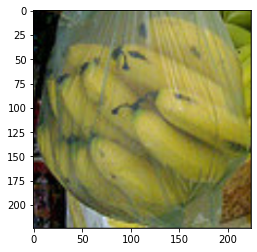

True Label :  0


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Prediction :  1


In [ ]:
test_img1 = test_imgs[0]
test_label1 = jax.device_get(test_labels)[0]

viewable_img1 = ((test_img1 - test_img1.min()) / (test_img1.max() - test_img1.min())) * 255.0
plt.imshow(viewable_img1.astype(jnp.uint8))
plt.show()

print("True Label : ", test_label1)
print(
    "Prediction : ",
    jax.device_get(
        jnp.argmax(
            jax.nn.softmax(
                trained_state.apply_fn(
                    {"params": trained_state.params, "batch_stats": trained_state.batch_stats},
                    test_img1.reshape(1, 224, 224, 3),
                )
            )
        )
    ),
)

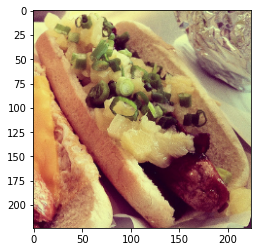

True Label :  1


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Prediction :  1


In [ ]:
test_img2 = test_imgs[1]
test_label2 = jax.device_get(test_labels)[1]

viewable_img2 = ((test_img2 - test_img2.min()) / (test_img2.max() - test_img2.min())) * 255.0
plt.imshow(viewable_img2.astype(jnp.uint8))
plt.show()

print("True Label : ", test_label2)
print(
    "Prediction : ",
    jax.device_get(
        jnp.argmax(
            jax.nn.softmax(
                trained_state.apply_fn(
                    {"params": trained_state.params, "batch_stats": trained_state.batch_stats},
                    test_img2.reshape(1, 224, 224, 3),
                )
            )
        )
    ),
)